<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Transfer%20Learning/Transfer_Learning_in_Tensorflow_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Fine Tuning

In [2]:
!nvidia-smi

Tue Jan 17 08:12:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    14W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Helper Functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-17 08:15:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-17 08:15:01 (86.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## 2. Importing Dataset

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-17 08:21:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  15.4MB/s    in 12s     

2023-01-17 08:21:38 (13.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
unzip_data("10_food_classes_10_percent.zip")

In [8]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

### 3. Creating Training and Test Datasets

In [9]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data = image_dataset_from_directory(
    directory=train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",batch_size = BATCH_SIZE,)
test_data = image_dataset_from_directory(
    directory=test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",batch_size = BATCH_SIZE,)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [17]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [19]:
class_names = train_data.class_names

In [24]:
for images,labels in train_data.take(1):
  print(images,labels)

tf.Tensor(
[[[[ 55.482143    47.070473    41.25893   ]
   [ 53.468433    43.51467     46.017857  ]
   [ 91.00734     68.86416     70.560905  ]
   ...
   [  5.           5.           7.        ]
   [  5.           5.           7.        ]
   [  5.           4.           9.        ]]

  [[ 57.647003    45.188778    30.205038  ]
   [ 62.35077     49.365112    43.71301   ]
   [ 68.27136     45.620533    40.759563  ]
   ...
   [  5.9285717    5.9285717    7.9285717 ]
   [  5.9285717    5.9285717    7.9285717 ]
   [  5.9285717    4.9285717    9.928572  ]]

  [[ 61.0676      45.57621     28.125956  ]
   [ 59.80963     45.67283     34.834503  ]
   [ 61.41167     42.764347    34.277424  ]
   ...
   [  6.           6.           8.        ]
   [  6.           6.           8.        ]
   [  6.           5.          10.        ]]

  ...

  [[ 27.491377    19.491377     6.4913764 ]
   [ 29.058037    21.058037     8.058036  ]
   [ 30.          22.           9.        ]
   ...
   [ 38.148907    34.148

## 4. Model 0  using Functional API

In [30]:
## Feature Extraction Base Model
base_model = tf.keras.applications.EfficientNetB0(include_top = False,classes = 10)

## Freeze hidden layers
base_model.trainable = False

## Create Inputs
inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer")

## Rescaling Inputs
##x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

## Pass inputs to base_model
x = base_model(inputs)
print(x.shape)

## Average Pool outputs of base model(aggregate important features)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

## outputs
outputs = tf.keras.layers.Dense(10,activation = "softmax",name = "output_layer")(x)

model_0 = tf.keras.Model(inputs,outputs)
model_0.compile(loss = "categorical_crossentropy",metrics = ["accuracy"],optimizer = "adam")
history_0 = model_0.fit(train_data,epochs = 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = 0.25*len(test_data),
            batch_size = 32,
            callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",experiment_name = "model_0")]
            )

(None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20230117-090258
Epoch 1/5
24/24 [==============================] - 11s 222ms/step - loss: 1.8855 - accuracy: 0.4147 - val_loss: 1.3287 - val_accuracy: 0.7281
Epoch 2/5
24/24 [==============================] - 4s 159ms/step - loss: 1.1000 - accuracy: 0.7773 - val_loss: 0.9064 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 5s 188ms/step - loss: 0.7928 - accuracy: 0.8453 - val_loss: 0.7279 - val_accuracy: 0.8344
Epoch 4/5
24/24 [==============================] - 5s 187ms/step - loss: 0.6432 - accuracy: 0.8627 - val_loss: 0.6458 - val_accuracy: 0.8391
Epoch 5/5
24/24 [==============================] - 5s 213ms/step - loss: 0.5536 - accuracy: 0.8853 - val_loss: 0.5777 - val_accuracy: 0.8625


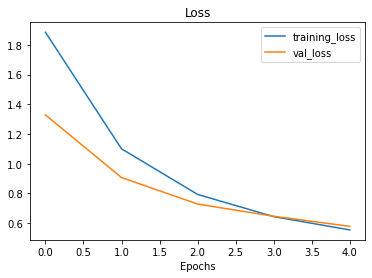

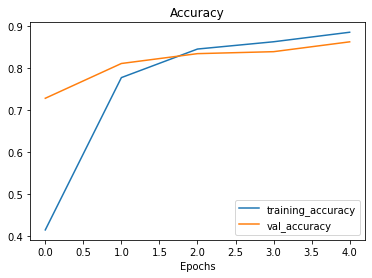

In [31]:
plot_loss_curves(history_0)

In [34]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_5 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   7          ['rescaling_5[0][0]']            
 )                              3)                                                   

In [35]:
model_0.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Getting a feature vector from trained model

In [40]:
input_shape = (1,4,4,1280)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 1280), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 , ...,  1.2239345 ,
          -0.16379032,  1.3785535 ],
         [-1.5401999 , -1.1970718 , -1.015505  , ..., -0.8313968 ,
           0.74773836,  1.5651373 ],
         [ 0.36974242, -2.0133252 ,  0.47674894, ..., -0.6174499 ,
          -0.9251019 , -0.5292798 ],
         [-1.2504278 , -0.2144383 , -0.13486972, ...,  0.1310723 ,
          -0.67270845, -1.3278127 ]],

        [[-1.4459095 ,  2.4189284 ,  0.5931171 , ...,  0.4000347 ,
           0.1045026 , -0.3930959 ],
         [-0.3357459 , -0.00592449,  0.19016078, ..., -2.6061013 ,
          -0.85348386, -1.2106847 ],
         [-0.58915883,  0.9554476 , -0.5978648 , ...,  0.35086414,
          -1.3153442 , -0.39510018],
         [ 1.2976652 , -1.1689845 ,  1.4274497 , ...,  1.5532643 ,
           1.7227225 , -1.653484  ]],

        [[-0.15505238,  1.1058683 ,  0.5083057 , ...,  1.4900261 ,
           0.19724938,  0.7874311 ],
   

In [43]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [45]:
global_average_pooled_tensor

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[-0.16287075,  0.06647376,  0.24605213, ...,  0.05889808,
        -0.30397308,  0.03896669]], dtype=float32)>

## One Percent Data Augmentation

In [46]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-01-17 09:41:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  16.0MB/s    in 9.5s    

2023-01-17 09:41:24 (13.4 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [47]:
unzip_data("10_food_classes_1_percent.zip")

In [48]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [49]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


### Data Loaders

In [50]:
IMG_SIZE =  (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
    )
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
    )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [51]:
print(tf.__version__)

2.9.2


## Adding Data Augmentation

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [71]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) 

],name = "data_augmentation")

## Visualizing data augmentation

(-0.5, 542.5, 378.5, -0.5)

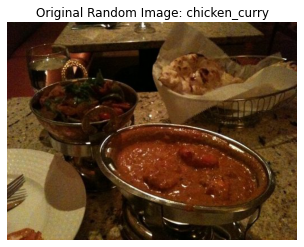

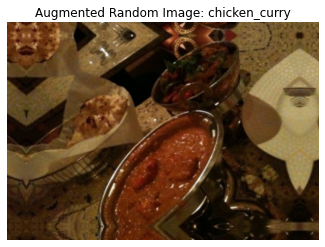

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image
img = mpimg.imread(random_image_path)
plt.title("Original Random Image: {}".format(target_class))
plt.axis(False)
plt.imshow(img)
img_augmented = data_augmentation(tf.expand_dims(img,axis = 0),training = True)
plt.figure()
plt.imshow(tf.squeeze(img_augmented)/255.)
plt.title("Augmented Random Image: {}".format(target_class))
plt.axis(False)

## Model 1: Feature Extraction using Data Augmentation

In [82]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Creating Layers
inputs = layers.Input(shape = input_shape,name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)

# Pool output
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(10,activation = "softmax",name = "output_layer")(x)
model_1 = keras.Model(inputs,outputs)
model_1.compile(loss = "categorical_crossentropy",metrics = ["accuracy"],optimizer = "adam")
history_1 = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = 0.25*len(test_data_1_percent),
    callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",experiment_name = "model_1")]
)

Saving TensorBoard log files to: transfer_learning/model_1/20230117-101043
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3670 - accuracy: 0.1143 - val_loss: 2.2768 - val_accuracy: 0.1484
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1175 - accuracy: 0.3000 - val_loss: 2.1458 - val_accuracy: 0.2031
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9762 - accuracy: 0.3714 - val_loss: 2.0318 - val_accuracy: 0.2984
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7608 - accuracy: 0.5429 - val_loss: 1.9211 - val_accuracy: 0.3828
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5821 - accuracy: 0.7286 - val_loss: 1.8369 - val_accuracy: 0.4359


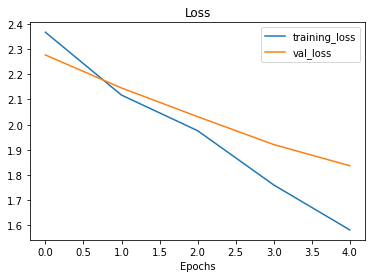

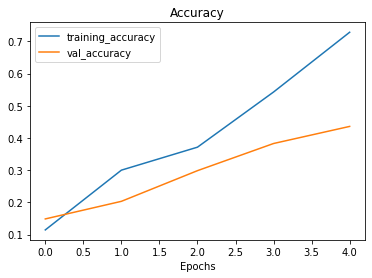

In [83]:
plot_loss_curves(history_1)

In [84]:
model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina